In [287]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


In [288]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

GPU name: NVIDIA A100-PCIE-40GB 



'cuda'

# Load MNIST dataset


In [330]:
rotation = 10
translation = (0.1, 0.1)
scaling = (0.9, 1.1)
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomAffine(degrees=[-rotation, rotation], 
                                                        translate=translation, 
                                                        scale=scaling),
    
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])
test_transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])


training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=test_transform)

In [332]:
from collections import defaultdict
from torch.utils.data import Subset
import numpy as np

# Group indices of each digit in the training dataset
digit_indices = defaultdict(list)
for idx, (image, label) in enumerate(training_dataset):
    digit_indices[label].append(idx)

# Stratify split by digits
train_indices = []
val_indices = []

for digit, indices in digit_indices.items():
    np.random.shuffle(indices)  # Shuffle indices for each digit
    split = int(0.8 * len(indices))  # 80% training, 20% validation
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

# Create Subset datasets for training and validation
train_dataset = Subset(training_dataset, train_indices)
val_dataset = Subset(training_dataset, val_indices)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Optional: Verify the distribution of digits
train_digit_counts = defaultdict(int)
val_digit_counts = defaultdict(int)

for _, label in train_dataset:
    train_digit_counts[label] += 1

for _, label in val_dataset:
    val_digit_counts[label] += 1

print("Training digit distribution:", dict(train_digit_counts))
print("Validation digit distribution:", dict(val_digit_counts))


Training set size: 47995
Validation set size: 12005
Training digit distribution: {5: 4336, 0: 4738, 4: 4673, 1: 5393, 9: 4759, 2: 4766, 3: 4904, 6: 4734, 7: 5012, 8: 4680}
Validation digit distribution: {5: 1085, 0: 1185, 4: 1169, 1: 1349, 9: 1190, 2: 1192, 3: 1227, 6: 1184, 7: 1253, 8: 1171}


# Define dataloaders


In [342]:

batch = 64

training_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True, drop_last=True,num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True,num_workers=4, pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True,num_workers=4, pin_memory=True)

(-0.5, 273.5, 273.5, -0.5)

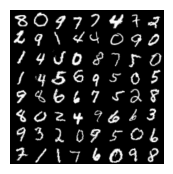

In [343]:
images = next(iter(training_dataloader))[0]
images = next(iter(training_dataloader))[0]

grid = make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

# Define Linear_Variance_Scheduler


In [381]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples,sample_steps, channels, img_size, wanted_class=None):
        model.eval()
        model = model.to(self.device)
        if wanted_class is not None:
            wanted_class = wanted_class.to(self.device)
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = {}
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = {}

                if wanted_class is not None:
                    pred_noise = model(x, wanted_class,t)
                else:
                    pred_noise = model(x,None, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if i in sample_steps:
                    collect[i] = x.detach().cpu()
        return x, collect

In [345]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class Cosine_Variance_Scheduler:
    def __init__(self, time_steps, s=0.008, device='cuda'):
        self.time_steps = time_steps
        self.s = s
        self.device = device

        steps = torch.arange(self.time_steps + 1, dtype=torch.float64, device=self.device)  # T+1 steps for cosine schedule
        t = steps / self.time_steps

        # Compute alpha_bar using cosine schedule
        f = lambda t: torch.cos((t + self.s) / (1 + self.s) * math.pi / 2) ** 2
        zero_t = torch.tensor(0.0, dtype=torch.float64, device=self.device)
        alphas_cumprod = f(t) / f(zero_t)

        # alphas_cumprod[0] corresponds to time step -1, so shift by 1
        self.alpha_bar = alphas_cumprod[1:].float()  # [T]
        
        # Now compute alphas and betas
        self.alphas = self.alpha_bar / torch.cat([torch.tensor([1.0], device=self.device), self.alpha_bar[:-1]])
        self.betas = 1 - self.alphas

        # Precompute square roots for efficiency
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process (updated to store samples like Linear_Variance_Scheduler)
    def ddpm_sampling(self, model, num_samples, sample_steps, channels, img_size, wanted_class=None):
        model.eval()
        model = model.to(self.device)
        if wanted_class is not None:
            wanted_class = wanted_class.to(self.device)
        
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = {}
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                
                if wanted_class is not None:
                    pred_noise = model(x, wanted_class, t)
                else:
                    pred_noise = model(x, t)
                
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                x = (1 / torch.sqrt(alphas)) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                
                # Save the sample if i is in sample_steps
                if i in sample_steps:
                    collect[i] = x.detach().cpu()
                    
        return x, collect


# Forward process output


In [346]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [347]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

### Play with forward parameters

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [348]:
import torch
import torch.nn as nn

def _find_closest_divisor_to_8(ch):
    # If divisible by 8, return 8
    if ch % 8 == 0:
        return 8
    
    # Find all divisors of ch
    divisors = [d for d in range(1, ch + 1) if ch % d == 0]
    
    # filter out options that are lower than 8
    divisors = [d for d in divisors if d >= 8]
    
    # Find the divisor closest to 8)
    closest = min(divisors, key=lambda x: abs(x - 8))
    print(f'Closest divisor to 8 for {ch} is {closest}')
    return closest

class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        
        # Determine the number of groups for GroupNorm layers
        groups_for_mid = _find_closest_divisor_to_8(mid_ch)
        groups_for_out = _find_closest_divisor_to_8(out_ch)
        
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1, padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=groups_for_mid, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=groups_for_out, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)


# Create SelfAttentionBlock

In [349]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# Create DownBlock

In [350]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UpBlock

In [351]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UNet

In [352]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

# FiLM layer for conditional training

In [353]:


class FiLM(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super(FiLM, self).__init__()
        self.gamma = nn.Linear(embedding_dim, in_channels)
        self.beta = nn.Linear(embedding_dim, in_channels)

    def forward(self, x, embedding):
        gamma = self.gamma(embedding).unsqueeze(-1).unsqueeze(-1)
        beta = self.beta(embedding).unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta


# Conditional Unet

In [354]:
class CondUNet(nn.Module):
    def __init__(self, t_emb_dim, num_classes=10, class_embedding_size=3, device='cuda'):
        super(CondUNet, self).__init__()
        self.device = device
        self.t_emb_dim = t_emb_dim

        # Class embedding layer
        self.class_embedding = nn.Embedding(num_classes, class_embedding_size)

        # Define your blocks
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        # FiLM layers
        self.film1 = FiLM(in_channels=64, embedding_dim=class_embedding_size)
        self.film2 = FiLM(in_channels=128, embedding_dim=class_embedding_size)
        self.film3 = FiLM(in_channels=256, embedding_dim=class_embedding_size)
        self.film4 = FiLM(in_channels=256, embedding_dim=class_embedding_size)
        self.film5 = FiLM(in_channels=128, embedding_dim=class_embedding_size)
        self.film6 = FiLM(in_channels=64, embedding_dim=class_embedding_size)

        # Positional embedding
        self.pos_embedding_i = 1 / (10000 ** (torch.arange(start=0, end=t_emb_dim, step=2) / t_emb_dim)).to(self.device)

    def position_embeddings(self, t, channels):
        pos_emb_sin = torch.sin(t.repeat(1, channels // 2) * self.pos_embedding_i)
        pos_emb_cos = torch.cos(t.repeat(1, channels // 2) * self.pos_embedding_i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, label, t):
        bs, _, w, h = x.shape

        # Obtain class embedding
        class_cond = self.class_embedding(label)


        # Time embedding
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        # Forward pass with FiLM conditioning
        x1 = self.inp(x)
        x1 = self.film1(x1, class_cond)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x2 = self.film2(x2, class_cond)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x3 = self.film3(x3, class_cond)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        x4 = self.film4(x4, class_cond)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.film5(x, class_cond)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.film6(x, class_cond)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output


# Conditional UNET simple

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F




class CondUNet2(nn.Module):
    def __init__(self, t_emb_dim, num_classes=10, class_embedding_size=4, device='cuda'):
        super(CondUNet2, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        self.class_embedding_size = class_embedding_size
        
        self.class_embedding = nn.Embedding(num_classes, class_embedding_size)
        
        # No embedding before inp
        self.inp = ResBlock(inp_ch=1+class_embedding_size, out_ch=64)
        
        # Down path (embedding before each down block)
        # down1: input after embedding = 64 + 4 = 68 channels
        self.down1 = DownBlock(inp_ch=64+class_embedding_size, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        
        # down2: input after embedding = 128 + 4 = 132 channels
        self.down2 = DownBlock(inp_ch=128+class_embedding_size, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        
        # down3: input after embedding = 256 + 4 = 260 channels
        self.down3 = DownBlock(inp_ch=256+class_embedding_size, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        # Latent path (no embedding here)
        self.lat1 = ResBlock(inp_ch=256+class_embedding_size, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512+class_embedding_size, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512+class_embedding_size, out_ch=256)
        
        # Up path (embedding before each up block)
        # up1: after upsample and concat skip3 (256 from lat3 upsample + 256 from skip3) = 512 + 4 embedding = 516
        self.up1 = UpBlock(inp_ch=512+class_embedding_size, out_ch=128) 
        # We'll handle concatenation logic carefully below.
        self.sa4 = SelfAttentionBlock(channels=128)
        
        # up2: after up1 we have 128 channels, upsample to same dimension as skip2 (128),
        # total 128+128=256 + 4 embedding = 260
        self.up2 = UpBlock(inp_ch=256+class_embedding_size, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        
        # up3: after up2 we have 64 channels, skip1 = 64, total 128 + 4 embedding = 132
        self.up3 = UpBlock(inp_ch=128+class_embedding_size, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def concat_class_cond(self, x, class_cond):
        # x: [B, C, H, W]
        # class_cond: [B, class_embedding_size]
        B, _, H, W = x.shape
        class_cond_map = class_cond.unsqueeze(-1).unsqueeze(-1).expand(B, class_cond.shape[1], H, W)
        return torch.cat([x, class_cond_map], dim=1)
    
    def forward(self, x, label, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        
        
        if label is None:
            # Use a zero embedding
            class_cond = torch.zeros(x.shape[0], self.class_embedding_size, device=x.device)
        else:
            class_cond = self.class_embedding(label)
        # --- Down Sampling ---
        x = self.concat_class_cond(x, class_cond)
        x1 = self.inp(x)         # (B,64,H,W)
        skip1 = x1
        
        # before down1
        x1 = self.concat_class_cond(x1, class_cond) 
        x2 = self.down1(x1, t)   # (B,128,H/2,W/2)
        # no embedding before sa1
        x2 = self.sa1(x2)        # (B,128,H/2,W/2)
        skip2 = x2
        
        # before down2
        x2 = self.concat_class_cond(x2, class_cond)
        x3 = self.down2(x2, t)   # (B,256,H/4,W/4)
        x3 = self.sa2(x3)        # (B,256,H/4,W/4)
        skip3 = x3
        
        # before down3
        x3 = self.concat_class_cond(x3, class_cond)
        x4 = self.down3(x3, t)   # (B,256,H/8,W/8)
        x4 = self.sa3(x4)        # (B,256,H/8,W/8)
        
        # # --- Latent ---
        # x4 = self.lat1(x4)       # (B,512,H/8,W/8)
        # x4 = self.lat2(x4)       # (B,512,H/8,W/8)
        # x4 = self.lat3(x4)       # (B,256,H/8,W/8)
        
        # Latent
        x4 = self.concat_class_cond(x4, class_cond)
        x4 = self.lat1(x4)       # (B,512,H/8,W/8)
        
        x4 = self.concat_class_cond(x4, class_cond)
        x4 = self.lat2(x4)       # (B,512,H/8,W/8)
        
        x4 = self.concat_class_cond(x4, class_cond)
        x4 = self.lat3(x4)       # (B,256,H/8,W/8)
        
       

        x4 = self.concat_class_cond(x4, class_cond)
        x = self.up1(x4, skip3, t) # (B,128,H/4,W/4)
        
        x = self.sa4(x)           # (B,128,H/4,W/4)

        
        x = self.concat_class_cond(x, class_cond)
        x = self.up2(x, skip2, t) # (B,64,H/2,W/2)
        x = self.sa5(x)           # (B,64,H/2,W/2)
        
        
        x = self.concat_class_cond(x, class_cond)
        x = self.up3(x, skip1, t) # (B,64,H/2,W/2)
        x = self.sa6(x)           # (B,64,H/2,W/2)
        
        x = self.out(x)           # (B,1,H/2,W/2)
        return x
   


In [356]:
def initialize_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.MultiheadAttention):
        # in_proj_weight and in_proj_bias contains K, V and Q weights concatenated together for weights and biases.
        # so this initializes all the weights.
        nn.init.xavier_normal_(m.in_proj_weight)
        if m.in_proj_bias is not None:
            nn.init.constant_(m.in_proj_bias, 0)
        # The same for m.out_proj.weight an bias
        nn.init.xavier_normal_(m.out_proj.weight)
        if m.out_proj.bias is not None:
            nn.init.constant_(m.out_proj.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)



In [357]:
from torchinfo import summary

# summary(CondUNet(t_emb_dim=256), input_size=[(64, 1+3, 32, 32), (64,)])


# SET-UP

In [358]:



ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = CondUNet2(t_emb_dim=256, num_classes=10, class_embedding_size=8).to(device)
model = model.apply(initialize_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Closest divisor to 8 for 260 is 10
Closest divisor to 8 for 132 is 11
Closest divisor to 8 for 68 is 17


# TRAINING

In [359]:
import numpy as np
import torch
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# Set random seeds for reproducibility
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 10
training_loss, test_loss = [], []
condition_weight = 0.5

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.95)

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    model.train()
    for data, label in tqdm(training_dataloader):
        data, label = data.to(device), label.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)

        # Conditional prediction
        pred_noise_cond = model(xt, label, t)
        trng_batch_loss = (1 - condition_weight) * criterion(noise, pred_noise_cond)

        # Unconditional prediction
        pred_noise = model(xt, None, t)
        trng_batch_loss += condition_weight * criterion(noise, pred_noise)

        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())

    training_per_epoch_loss = np.mean(training_losses)

    model.eval()
    with torch.inference_mode():
        for data, label in tqdm(test_dataloader):
            data, label = data.to(device), label.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)

            # Conditional prediction during evaluation
            pred_noise_cond = model(xt, label, t)
            tst_batch_loss = (1 - condition_weight) * criterion(noise, pred_noise_cond)

            # Unconditional prediction during evaluation
            pred_noise = model(xt, None, t)
            tst_batch_loss += condition_weight * criterion(noise, pred_noise)

            test_losses.append(tst_batch_loss.item())

        test_per_epoch_loss = np.mean(test_losses)

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    # Step the scheduler
    scheduler.step()

    # Optionally, print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch {epoch+1}/{n_epochs} | Training loss: {training_per_epoch_loss:.4f} | '
          f'Test loss: {test_per_epoch_loss:.4f} | Learning Rate: {current_lr:.8f}')


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 156/156 [00:07<00:00, 20.17it/s]


Epoch 1/10 | Training loss: 0.0701 | Test loss: 0.0325 | Learning Rate: 0.00010000


100%|██████████| 156/156 [00:10<00:00, 15.09it/s]


Epoch 2/10 | Training loss: 0.0357 | Test loss: 0.0300 | Learning Rate: 0.00009500


100%|██████████| 156/156 [00:07<00:00, 20.26it/s]


Epoch 3/10 | Training loss: 0.0323 | Test loss: 0.0273 | Learning Rate: 0.00009500


100%|██████████| 156/156 [00:07<00:00, 20.11it/s]


Epoch 4/10 | Training loss: 0.0306 | Test loss: 0.0254 | Learning Rate: 0.00009025


100%|██████████| 156/156 [00:07<00:00, 20.21it/s]


Epoch 5/10 | Training loss: 0.0290 | Test loss: 0.0241 | Learning Rate: 0.00009025


100%|██████████| 156/156 [00:07<00:00, 20.23it/s]


Epoch 6/10 | Training loss: 0.0283 | Test loss: 0.0235 | Learning Rate: 0.00008574


100%|██████████| 156/156 [00:07<00:00, 20.18it/s]


Epoch 7/10 | Training loss: 0.0273 | Test loss: 0.0220 | Learning Rate: 0.00008574


100%|██████████| 156/156 [00:07<00:00, 20.15it/s]


Epoch 8/10 | Training loss: 0.0274 | Test loss: 0.0222 | Learning Rate: 0.00008145


100%|██████████| 156/156 [00:07<00:00, 20.20it/s]


Epoch 9/10 | Training loss: 0.0266 | Test loss: 0.0219 | Learning Rate: 0.00008145


 10%|█         | 75/749 [00:10<01:30,  7.44it/s]


KeyboardInterrupt: 

# Save model

In [360]:
# Save the model
torch.save(model.state_dict(), 'ddpm_cond_simple_2.pth')

# Load model

In [ ]:
# model = CondUNet(t_emb_dim=256, num_classes=10, class_embedding_size=5, device='cuda')
# # Load the saved state dictionary
# model.load_state_dict(torch.load('ddpm_cond_unet.pth'))

# # Set the model to evaluation mode
# model.eval()

# Plot losses

# Reverse process

In [363]:
steps = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]


ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02, device='cuda')
# ddpm = Cosine_Variance_Scheduler(time_steps=1000, device='cuda')

model = model.to('cuda')
_, collect = ddpm.ddpm_sampling(
    model=model, 
    num_samples=1,
    sample_steps=steps, 
    channels=1, 
    img_size=32, 
    wanted_class=torch.tensor([3], device='cuda'))


1000it [00:06, 144.44it/s]


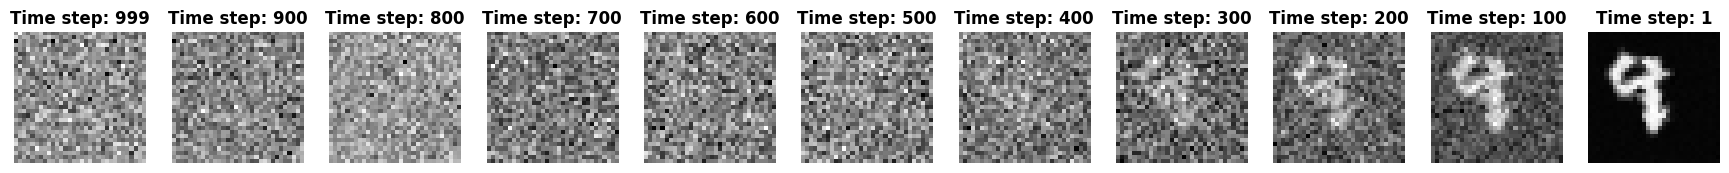

In [364]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, s in zip(axis.ravel(), steps):
    ax.imshow(collect[s][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {s}', fontweight='bold')
    ax.axis(False)
    j += 1

# Random sampling from noise

In [ ]:
imgs = []
step = 999

# sampled_imgs, _ = ddpm.ddpm_sampling(model=model, 
#                                          num_samples=100, 
#                                          channels=1,
#                                          sample_steps=[step],
#                                          img_size=32,
#                                          wanted_class=None)
# imgs.append(sampled_imgs)

for i in range(10):
    sampled_imgs, _ = ddpm.ddpm_sampling(model=model, 
                                         num_samples=32, 
                                         channels=1,
                                         sample_steps=[step],
                                         img_size=32,
                                         wanted_class=torch.tensor([i], device='cuda'))
    imgs.append(sampled_imgs)



1000it [00:36, 27.47it/s]


In [395]:
# flatten imgs
imgs = torch.cat(imgs, dim=0)

(-0.5, 341.5, 341.5, -0.5)

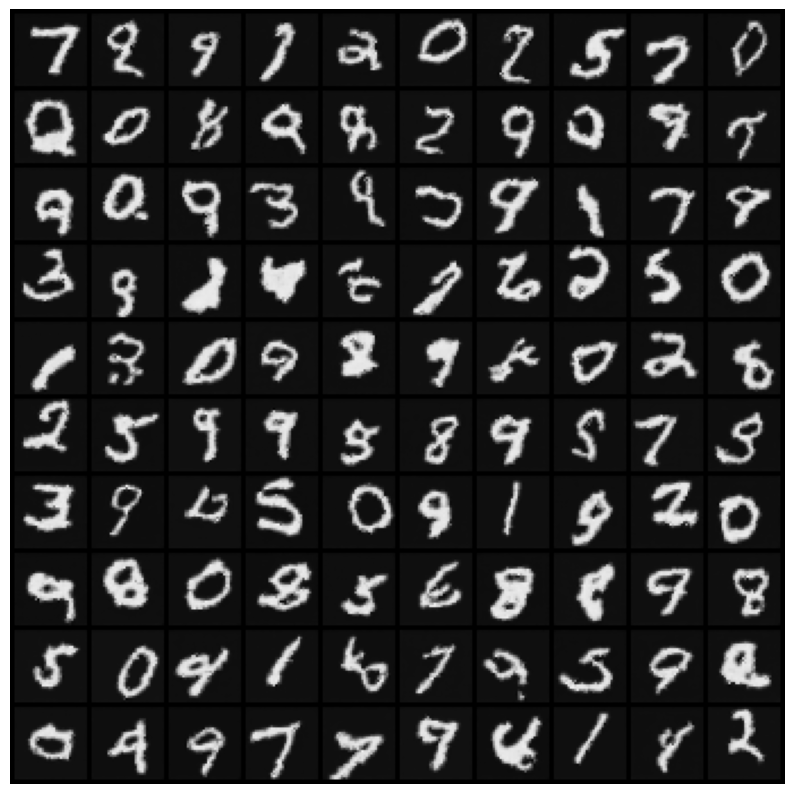

In [403]:
grid = make_grid(imgs.detach().cpu(), nrow=10, normalize=True)
plt.figure(figsize=(10, 12))  # Increase size here
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

# FID evaluation

In [368]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_gan as tfgan
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F



2024-12-06 15:56:32.647331: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 15:56:32.686533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 15:56:32.686564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 15:56:32.688092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 15:56:32.694904: I tensorflow/core/platform/cpu_feature_guar

In [375]:
def prepare_images(sampled_imgs):
    # Resize images from 32x32 to 28x28 using PyTorch
    sampled_imgs_resized = F.interpolate(sampled_imgs, size=(28, 28), mode='bilinear', align_corners=False)

    # Process resized images
    sampled_imgs_np = sampled_imgs_resized.cpu().numpy()  # Convert to NumPy array
    sampled_imgs_np = (sampled_imgs_np * 0.5) + 0.5       # Denormalize to [0, 1]
    sampled_imgs_np = np.clip(sampled_imgs_np, 0, 1)      # Ensure values are within [0, 1]
    sampled_imgs_np = np.transpose(sampled_imgs_np, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)

    # Convert to TensorFlow tensor
    sampled_imgs_tf = tf.convert_to_tensor(sampled_imgs_np, dtype=tf.float32)
    return sampled_imgs_tf

In [393]:
# Load the pre-trained MNIST classifier
MNIST_MODULE = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
mnist_classifier_fn = tfhub.load(MNIST_MODULE)


# Define the classifier function
def classifier_fn(images):
    outputs = mnist_classifier_fn(images=images)
    return outputs  # Outputs is a tensor of logits

# Function to compute activations
def compute_activations(images, num_batches, classifier_fn):
    images_list = tf.split(images, num_or_size_splits=num_batches)
    activations = []
    for batch in images_list:
        outputs = classifier_fn(images=batch)
        activations.append(outputs)
    activations = tf.concat(activations, axis=0)
    return activations

# Compute activations for real MNIST images
def load_mnist():
    ds = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.Resize((28, 28)),  # Ensure images are 28x28
            transforms.ToTensor(),
        ]),
    )
    dl = DataLoader(ds, batch_size=60000, shuffle=False)
    x, _ = next(iter(dl))
    x = x.numpy()  # Convert to NumPy array
    x = np.transpose(x, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)
    return tf.convert_to_tensor(x, dtype=tf.float32)

def Calculate_FID_for_Conditional(generated_images, mnist, classifier_fn):
    
    sampled_imgs_tf = prepare_images(generated_images)
    
    activations_real = compute_activations(
        mnist, num_batches=1, classifier_fn=classifier_fn)

    # Compute activations for generated images
    activations_fake = compute_activations(
        sampled_imgs_tf, num_batches=1, classifier_fn=classifier_fn)

    # Compute FID
    fid = tfgan.eval.frechet_classifier_distance_from_activations(
        activations_real, activations_fake)

    return fid

mnist_images_tf = load_mnist()


fid = Calculate_FID_for_Conditional(imgs, mnist_images_tf, classifier_fn)

print(f"FID: {fid.numpy()}")


FID: 9.608407020568848
